In [361]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from seaborn import pairplot
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, SequentialFeatureSelector
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from sklearn.metrics import r2_score, mean_squared_error

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [362]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#### Useful tools to evaluate model performance

In [363]:
def model_scorer(pred_model, x_train, y_train, cv = 3):
    pred_model.fit(x_train, y_train)
    normal_score = pred_model.score(x_train, y_train)
    rand_y = y_train.sample(frac = 1)
    pred_model.fit(x_train, rand_y)
    shuffle_score = pred_model.score(x_train, rand_y)
    pred_model.fit(x_train, y_train)
    cv_score = cross_validate(pred_model, x_train, y_train, cv = cv)
    return[normal_score, shuffle_score, cv_score]

In [364]:
all_data = pd.read_csv("data/molecules_descriptors_mordred.csv")
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(all_data.columns[[0, 1, -1]], axis=1), all_data.iloc[:,-1], test_size=0.33, random_state=42)
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.fit_transform(X_test)

### Find out a bit about the data - correlation

In [365]:
all_data_corr = all_data.drop(all_data.columns[[0,1]], axis = 1).corr(method="spearman")

Feature with highest (monotonic) correlation + its correlation

In [4]:
print(all_data_corr.index[np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2])
all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2]

SLogP


C:\Users\serra\AppData\Local\Temp\ipykernel_10044\1413788054.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2]


0.7462881435025174

Histogram of $log(\frac{1}{LC_{50}})$\
$LC_{50}$ -> the lower the more toxic, $\frac{1}{LC_{50}}$ -> the higher the more toxic

Text(0.5, 1.0, 'Test dataset compound toxicity')

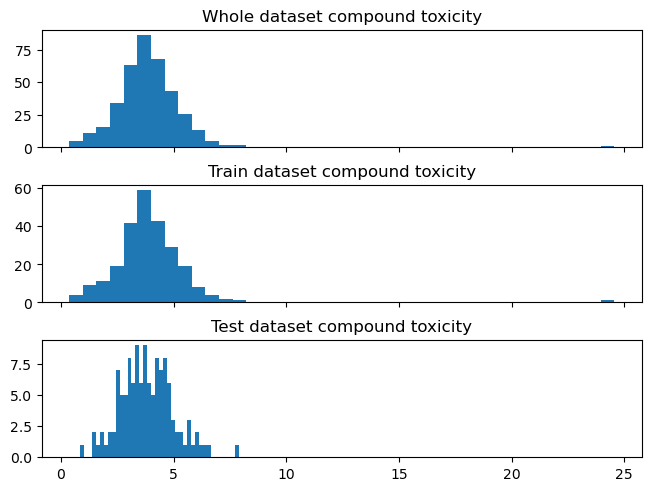

In [97]:
fig, axs = plt.subplots(3, 1, layout='constrained', sharex=True)
axs[0].hist(all_data["compound_toxicity"], bins = 40)
axs[1].hist(y_train, bins = 40)
axs[2].hist(y_test, bins = 40)
axs[0].set_title("Whole dataset compound toxicity")
axs[1].set_title("Train dataset compound toxicity")
axs[2].set_title("Test dataset compound toxicity")

Few super toxic compounds

#### Linear predictors

Starting with simple linear models with a shitty result (R^2)

In [99]:
sdg_regressor = SGDRegressor(max_iter=1000, tol=1e-20)
sdg_regressor.fit(scaled_x_train, y_train)
sdg_regressor.score(scaled_x_train, y_train)

-3.1595084636640354e+19

GLMs

In [367]:
clf1 = linear_model.PoissonRegressor(max_iter=10000)
clf1.fit(scaled_x_train, y_train)
print(clf1.score(scaled_x_train, y_train))

clf2 = linear_model.TweedieRegressor()
clf2.fit(scaled_x_train, y_train)
print(clf2.score(scaled_x_train, y_train))

clf3 = linear_model.GammaRegressor()
clf3.fit(scaled_x_train, y_train)
print(clf3.score(scaled_x_train, y_train))

0.7833917509210249
0.5462743205848692
0.756142865140929


In [369]:
clf1_pred = clf1.predict(scaled_x_train)
print(r2_score(y_train, clf1_pred))
mean_squared_error(y_train, clf1_pred)

0.6446682141841471


1.183103571972856

clf1 worked surprisingly well, tried some feature selection

In [54]:
rfe = RFE(estimator=clf1, n_features_to_select=10, step=1)
rfe.fit(scaled_x_train, y_train)

RFE(estimator=PoissonRegressor(max_iter=10000), n_features_to_select=10)

In [57]:
rfe.get_feature_names_out()

array(['x41', 'x134', 'x261', 'x339', 'x483', 'x598', 'x630', 'x672',
       'x673', 'x702'], dtype=object)

Backward feature selection with 3 x CV

In [73]:
sfs = SequentialFeatureSelector(clf1, n_features_to_select=20, direction="forward", cv = 3, n_jobs=-1,
                                scoring="r2")
sfs.fit(scaled_x_train, y_train)
clf1.fit(scaled_x_train[:,sfs.get_support()], y_train)
clf1.score(scaled_x_train[:,sfs.get_support()], y_train)

0.557032689313979

In [81]:
sfs.get_feature_names_out()

array(['x134', 'x325', 'x354', 'x357', 'x364', 'x446', 'x459', 'x470',
       'x509', 'x565', 'x566', 'x581', 'x583', 'x598', 'x611', 'x613',
       'x620', 'x627', 'x672', 'x673'], dtype=object)

In [82]:
model_scorer(clf1, scaled_x_train, y_train, cv=5)

[0.7833917509210249,
 0.5315954755276138,
 {'fit_time': array([0.03315663, 0.03600025, 0.03299952, 0.03099966, 0.03200126]),
  'score_time': array([0.00084567, 0.00099897, 0.        , 0.00099921, 0.00099921]),
  'test_score': array([-0.12131554,  0.51210373,  0.68741997,  0.59362728,  0.13317448])}]

MultiTaskElasticNetCV

In [41]:
clf = linear_model.ElasticNetCV(cv=3, max_iter=10000)
clf.fit(scaled_x_train, y_train)
print(clf.score(scaled_x_train, y_train))

0.4211111508850851


#### Continuing with Support Vector Regression

In [42]:
svr = GridSearchCV(
    SVR(gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e4, 1e5, 1e50], "gamma": np.logspace(-2, 1, 2, 4), "kernel":["poly", "rbf"]},
)
svr.fit(scaled_x_train, y_train)
svr.best_score_

0.21370218639357924

### Trying out NN

Training function

In [374]:
def train_nn_model(nn_model, train_data_features, train_data_res, test_data_features, test_data_res,
                   n_epochs = 20, batch_size = 5):

    batch_start = torch.arange(0, len(X_train), batch_size)
    X_train_torch = torch.tensor(train_data_features, dtype=torch.float32)
    y_train_torch = torch.tensor(train_data_res.to_list(), dtype=torch.float32).reshape(-1, 1)
    X_test_torch = torch.tensor(test_data_features, dtype=torch.float32)
    y_test_torch = torch.tensor(test_data_res.to_list(), dtype=torch.float32).reshape(-1, 1)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(nn_model.parameters(), lr = 0.0001)
    
    train_history = []
    test_history = []
    # training loop
    best_mse = np.inf
    for epoch in range(n_epochs):
        nn_model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train_torch[start:start+batch_size]
                y_batch = y_train_torch[start:start+batch_size]
                # forward pass
                y_pred = nn_model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        nn_model.eval()
        y_pred_test = nn_model(X_test_torch)
        mse_test = r2_score(y_pred_test.detach().numpy(), y_test_torch.detach().numpy())
        mse_test = float(mse_test)
        test_history.append(mse_test)

        y_pred_train = nn_model(X_train_torch)
        mse_train = r2_score(y_pred_train.detach().numpy(), y_train_torch.detach().numpy())
        mse_train = float(mse_train)
        train_history.append(mse_train)
        if mse_test < best_mse:
            best_mse = mse_test
            best_weights = copy.deepcopy(nn_model.state_dict())
    
    # restore nn_model and return best accuracy
    nn_model.load_state_dict(best_weights)
    return [train_history, test_history]

In [418]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=False)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        print(x)
        print(x.size())
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        print(hidden.size())

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        print("got out")
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [419]:
# Define the model
#model = nn.Sequential(
#    nn.Linear(732, 366),
#    nn.ReLU(),
#    nn.RNN(366, 100),
#    nn.Linear(366, 1),
#)
model = Model(732, 1, hidden_dim=10, n_layers=1)

In [420]:
train_history, test_history = train_nn_model(model, scaled_x_train, y_train, scaled_x_test, y_test)

tensor([[-0.0632, -0.2318,  2.0435,  ...,  1.0217, -0.4418,  0.8471],
        [-0.0632, -0.2318,  0.4398,  ...,  0.7570,  1.1445,  0.5002],
        [-0.0632, -0.2318,  2.0435,  ...,  1.0217, -0.4418,  0.8471],
        [-0.0632, -0.2318,  0.4398,  ...,  0.1897,  0.0394,  0.1532],
        [-0.0632, -0.2318, -1.1639,  ..., -1.1718, -0.5844, -0.9192]])
torch.Size([5, 732])
torch.Size([1, 5, 10])


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [393]:
test_history

[-5.770834649693492,
 -0.3851212597567557,
 0.10344221979579304,
 0.24603028507517322,
 0.3020276136901233,
 0.32808010704214297,
 0.3462657176888959,
 0.3584504557599373,
 0.36672729822879346,
 0.3718323130415184,
 0.3772613321665853,
 0.37752163422080065,
 0.37787852934343824,
 0.3785345267772099,
 0.3768957895098358,
 0.37555005525679264,
 0.3714994881071195,
 0.3688304518532579,
 0.36613720805492356,
 0.36251302515400674]

Text(0.5, 1.0, 'Test MSE')

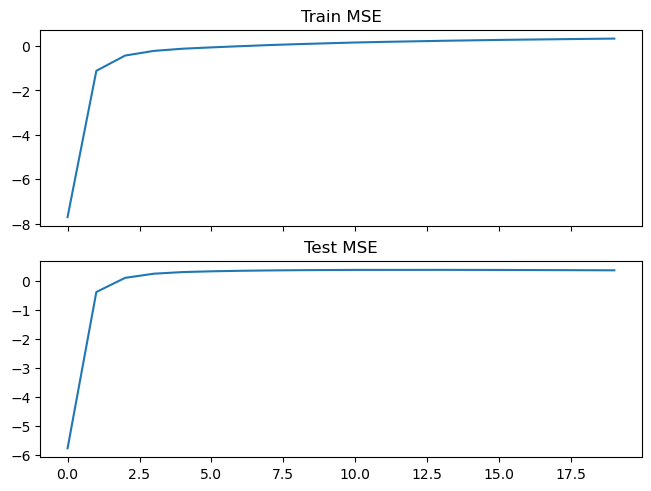

In [394]:
fig, axs = plt.subplots(2, 1, layout='constrained', sharex=True)
axs[0].plot(train_history)
axs[0].set_title("Train MSE")
axs[1].plot(test_history)
axs[1].set_title("Test MSE")